# 🎓 **Taller 4.6.2: Taller de Métodos de Clustering Basados en Densidad**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos de clustering basado en Densidad los cuales agrupan puntos de datos basándose en regiones de alta densidad de puntos, separadas por regiones de baja densidad.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

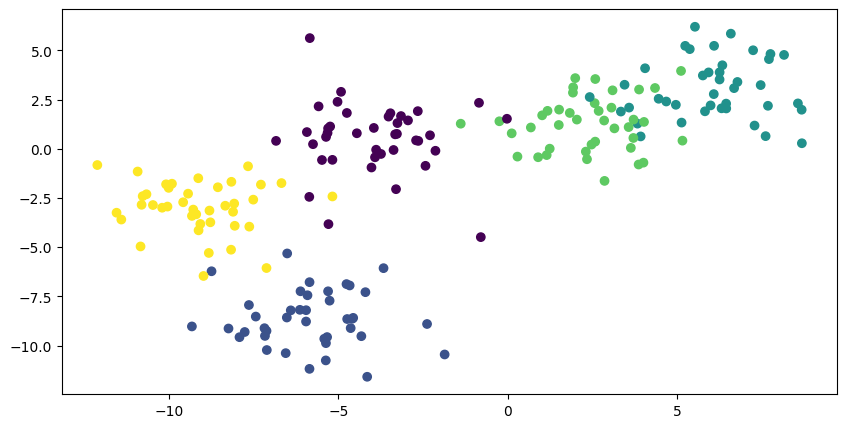

In [3]:
from sklearn.datasets import make_blobs

np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

Dx, Dy = make_blobs(200, 2, centers=5, cluster_std=1.5)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

# 🎯 **1:Cree el Algoritmo de Clustering Mean Shift**

## Calcular el Kernel Gausiano


In [4]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

El algoritmo MeanShift usa la función kernel para delimitar el vecindario y devolver el peso de cada instancia del vecindario

In [6]:
def kernel_gaussiano(mDistancia, i, h):
    dist = mDistancia[i, :]
    # Kernel gaussiano: exp(-dist^2 / (2*h^2))
    weights = np.exp(-(dist**2) / (2 * h**2))
    # Solo se aceptan los que estén en el vecindario (bandwidth efectivo)
    weights[weights <= (1.0 / np.e)] = 0
    return weights

Complete la función que calcula el vector shift y el centro de masa ponderado

In [7]:
def mean_shift_vector(X, weights, i):
    # Asegurar que weights tenga la forma correcta
    weights = weights.reshape(-1, 1)
    # Calcular centro de masa ponderado
    numerador = np.sum(weights * X, axis=0)
    denominador = np.sum(weights)
    if denominador > 0:
        centro_masa_ponderado = numerador / denominador
        shift = centro_masa_ponderado - X[i, :]
        return centro_masa_ponderado, shift
    else:
        return X[i, :], np.zeros_like(X[i, :])

Ahora cree el algoritmo mean shift iterativo

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=100, tolerancia=1e-5):
    actDx = np.copy(Dx)
    n_muestras = actDx.shape[0]

    # Historial de trayectorias para graficar (opcional)
    trayectorias = np.zeros((n_iteraciones, n_muestras, actDx.shape[1]))

    for iteracion in range(n_iteraciones):
        actDx_anterior = np.copy(actDx)
        mDistancia = matriz_distancias(actDx, distancia_euclidiana)
        for i in range(n_muestras):
            # Calcular pesos usando kernel gaussiano
            weights = kernel_gaussiano(mDistancia, i, h)  # p4
            # Calcular nuevo centro de masa
            nuevo_punto, shift = mean_shift_vector(actDx, weights, i)  # p5
            actDx[i, :] = nuevo_punto
        # Guardar trayectoria (opcional)
        trayectorias[iteracion, :, :] = actDx
        # Verificar convergencia
        desplazamiento_total = np.mean(np.sqrt(np.sum((actDx - actDx_anterior)**2, axis=1)))  # p6
        if iteracion % 3 == 0:
            print(f"Iteración {iteracion}: Desplazamiento medio = {desplazamiento_total:.6f}")

        if desplazamiento_total < tolerancia:
            print(f"Convergencia alcanzada en iteración {iteracion}")
            trayectorias = trayectorias[:iteracion+1, :, :]
            break

    # Asignar cada punto al centroide más cercano
    asignacion = np.zeros(n_muestras, dtype=int)  # p7
    for i in range(n_muestras):
        distancias = np.sqrt(np.sum((actDx[i, :] - centros)**2, axis=1))
        asignacion[i] = np.argmin(distancias)

    centros = np.unique(np.round(actDx, 3), axis=0)
    return np.array(centros), asignacion, trayectorias[:iteracion+1, :, :]

Esta función permite vizuaizar la asignacion de los puntos a los clusters y la trayectoria de algunos puntos desde su posicion inicial al centro del cluster

In [15]:
from sklearn.metrics.pairwise import euclidean_distances

def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=100, tolerancia=1e-5):
    actDx = np.copy(Dx)
    n_muestras = actDx.shape[0]

    # Historial de trayectorias para graficar (opcional)
    trayectorias = np.zeros((n_iteraciones, n_muestras, actDx.shape[1]))

    for iteracion in range(n_iteraciones):
        actDx_anterior = np.copy(actDx)
        mDistancia = matriz_distancias(actDx, distancia_euclidiana)
        for i in range(n_muestras):
            # Calcular pesos usando kernel gaussiano
            weights = kernel_gaussiano(mDistancia, i, h)  # p4
            # Calcular nuevo centro de masa
            nuevo_punto, shift = mean_shift_vector(actDx, weights, i)  # p5
            actDx[i, :] = nuevo_punto
        # Guardar trayectoria (opcional)
        trayectorias[iteracion, :, :] = actDx
        # Verificar convergencia
        desplazamiento_total = np.mean(np.sqrt(np.sum((actDx - actDx_anterior)**2, axis=1)))  # p6
        if iteracion % 3 == 0:
            print(f"Iteración {iteracion}: Desplazamiento medio = {desplazamiento_total:.6f}")

        if desplazamiento_total < tolerancia:
            print(f"Convergencia alcanzada en iteración {iteracion}")
            trayectorias = trayectorias[:iteracion+1, :, :]
            break

    # PRIMERO calcular los centros
    centros = np.unique(np.round(actDx, 3), axis=0)

    # LUEGO asignar cada punto al centroide más cercano
    asignacion = np.zeros(n_muestras, dtype=int)
    for i in range(n_muestras):
        distancias = np.sqrt(np.sum((actDx[i, :] - centros)**2, axis=1))
        asignacion[i] = np.argmin(distancias)

    return np.array(centros), asignacion, trayectorias[:iteracion+1, :, :]

## Ahora ya estamos en disposición de realizar el Mean Shift.


Iteración 0: Desplazamiento medio = 1.483052
Iteración 3: Desplazamiento medio = 0.575815
Iteración 6: Desplazamiento medio = 0.000758
Iteración 9: Desplazamiento medio = 0.000002
Convergencia alcanzada en iteración 9

Número de clusters encontrados: 2
Centroides: [[-5.765 -3.711]
 [ 2.708  1.706]]


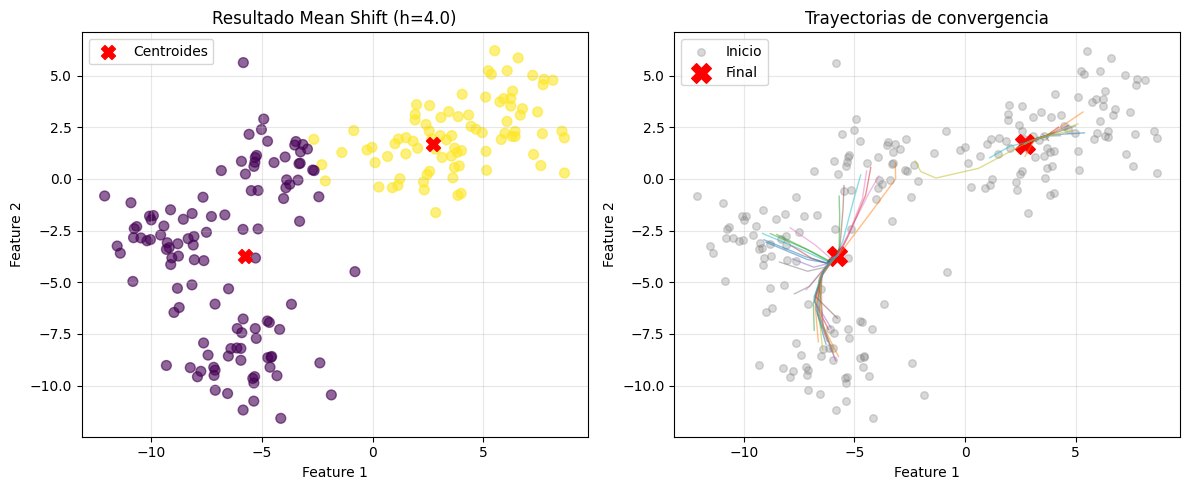

In [16]:
# Aplicar Mean Shift
h = 4.0  # Bandwidth
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)

print(f"\nNúmero de clusters encontrados: {len(centroides)}")
print(f"Centroides: {centroides}")

# Visualizar resultados
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

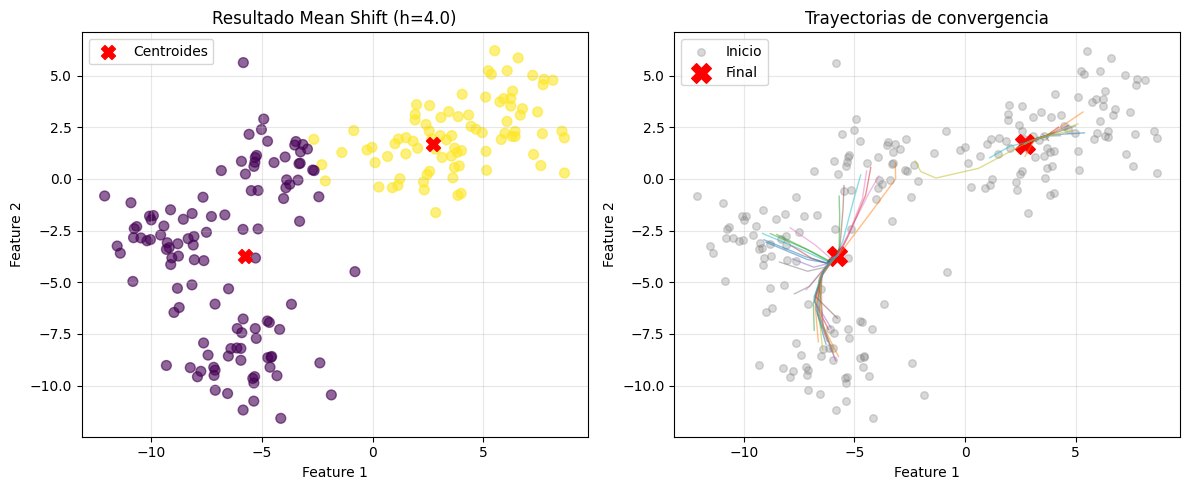

In [17]:
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

<hr>
Podemos jugar con diferentes valores de $\epsilon$ y $M$ para ver su efecto sobre diferentes conjuntos de datos:


In [18]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


Iteración 0: Desplazamiento medio = 0.001371
Iteración 3: Desplazamiento medio = 0.000444
Iteración 6: Desplazamiento medio = 0.000124
Iteración 9: Desplazamiento medio = 0.000010
Convergencia alcanzada en iteración 9

Número de clusters encontrados: 494


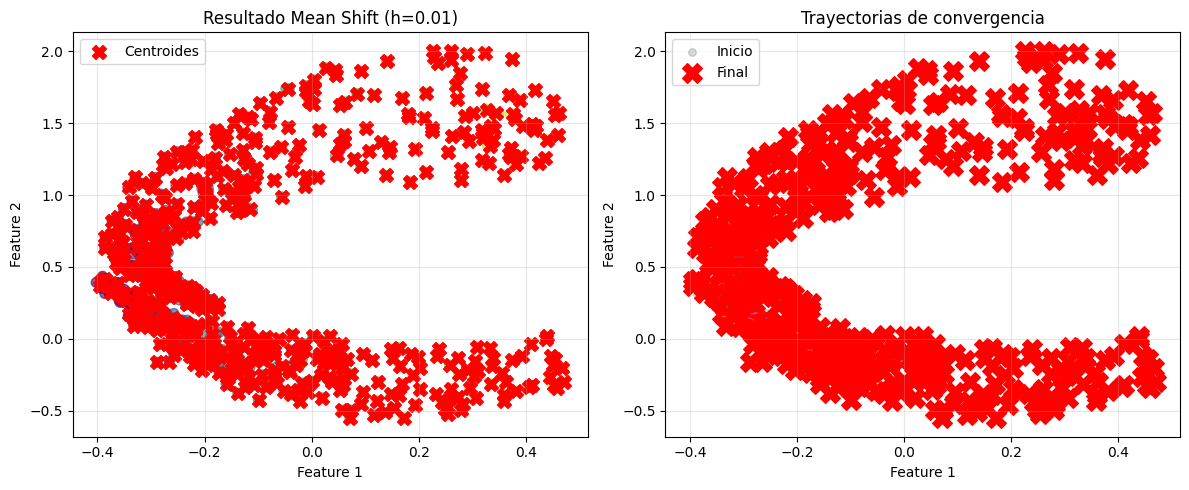

In [20]:
# Aplicar Mean Shift
h = 0.01
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 0.071508
Iteración 3: Desplazamiento medio = 0.050832
Iteración 6: Desplazamiento medio = 0.001665
Iteración 9: Desplazamiento medio = 0.000005
Convergencia alcanzada en iteración 9

Número de clusters encontrados: 4


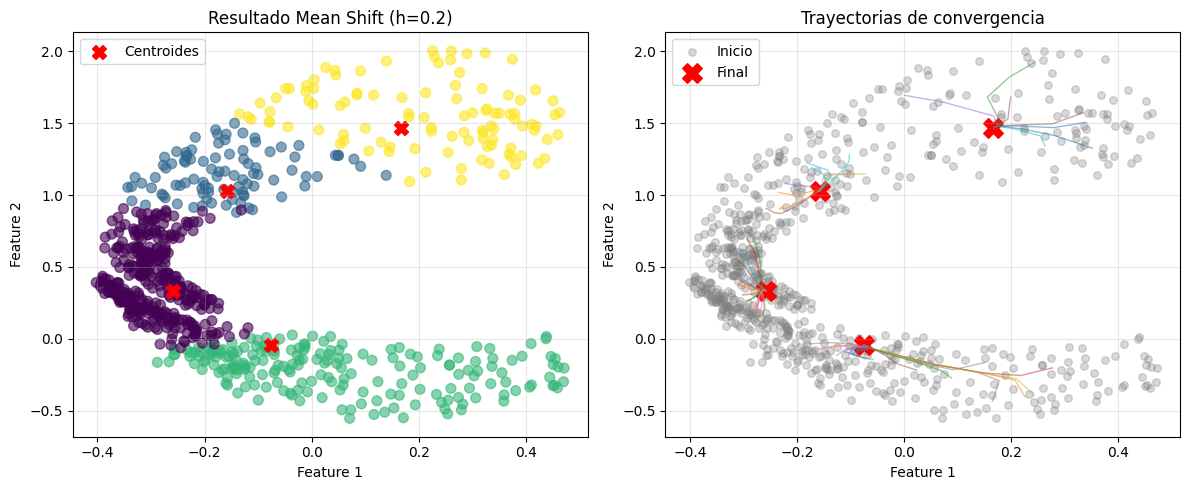

In [21]:
# Aplicar Mean Shift
h = 0.2
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

Iteración 0: Desplazamiento medio = 0.206196
Iteración 3: Desplazamiento medio = 0.111036
Iteración 6: Desplazamiento medio = 0.000037
Convergencia alcanzada en iteración 7

Número de clusters encontrados: 1


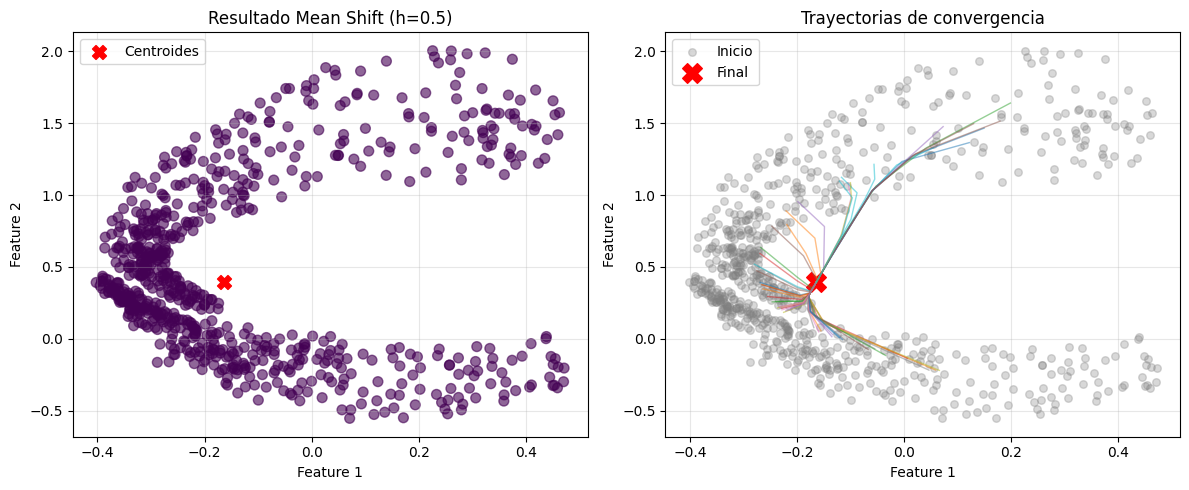

In [22]:
# Aplicar Mean Shift
h = 0.5
centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones=50)
print(f"\nNúmero de clusters encontrados: {len(centroides)}")
visualizar_proceso_mean_shift(Dx, h, centroides, etiquetas, trayectorias)

## Definir el rango de experimentación de h

Complete el calculo de los metodos para definir h

In [23]:
def calcular_h_automatico(X, metodo='silverman', dimension=None):
    n_muestras, n_caracteristicas = X.shape
    if metodo == 'silverman':
        # Regla de Silverman para múltiples dimensiones
        # h = σ * n^{-1/(d+4)}
        if dimension is None:
            # Usar promedio de desviaciones estándar
            sigma = np.mean(np.std(X, axis=0))
        else:
            sigma = np.std(X[:, dimension])
        h = sigma * (n_muestras ** (-1.0 / (n_caracteristicas + 4)))  # p11
        info = {
            'metodo': 'Regla de Silverman',
            'sigma': sigma,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas,
            'formula': 'h = σ * n^{-1/(d+4)}'
        }
    elif metodo == 'scott':
        # Regla de Scott: h = σ * n^{-1/(d+4)}
        # Similar a Silverman pero con factor diferente
        if dimension is None:
            sigma = np.mean(np.std(X, axis=0))
        else:
            sigma = np.std(X[:, dimension])
        # Factor de Scott: 1.06
        factor = 1.06
        h = factor * sigma * (n_muestras ** (-1.0 / (n_caracteristicas + 4)))  # p12
        info = {
            'metodo': 'Regla de Scott',
            'sigma': sigma,
            'factor': factor,
            'n_muestras': n_muestras,
            'n_caracteristicas': n_caracteristicas
        }

    elif metodo == 'rango':
        # Porcentaje del rango total de datos
        rangos = np.ptp(X, axis=0)  # peak-to-peak (máx - mín)
        rango_promedio = np.mean(rangos)
        # Usar 15% del rango como punto de partida
        porcentaje = 0.15
        h = rango_promedio * porcentaje  # p13

        info = {
            'metodo': 'Porcentaje del rango',
            'rango_promedio': rango_promedio,
            'porcentaje': porcentaje,
            'rangos_individuales': rangos.tolist()
        }

    elif metodo == 'std':
        # Fracción de la desviación estándar
        stds = np.std(X, axis=0)
        std_promedio = np.mean(stds)

        # Usar 1/3 de la desviación estándar
        fraccion = 0.33
        h = std_promedio * fraccion  # p14

        info = {
            'metodo': 'Fracción de desviación estándar',
            'std_promedio': std_promedio,
            'fraccion': fraccion,
            'stds_individuales': stds.tolist()
        }

    else:
        raise ValueError(f"Método '{metodo}' no reconocido. Usar: 'silverman', 'scott', 'rango', 'std'")
    return h, info

Experimente con el dataset

In [ ]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

In [ ]:
# Métodos a evaluar
metodos = ['silverman', 'scott', 'rango', 'std']

print("\n" + "="*70)
print("CÁLCULO DE BANDWIDTH (h) CON DIFERENTES MÉTODOS")
print("="*70)
# Calcular h para cada método
for metodo in metodos:
    h_base, info = calcular_h_automatico(Dx, metodo)
    print(f"\nMétodo: {metodo.upper()}")
    print(f"  h calculado: {h_base:.6f}")

    # Información adicional específica por método
    if 'sigma' in info:
        print(f"  Sigma usado: {info['sigma']:.6f}")
    if 'rango_promedio' in info:
        print(f"  Rango promedio: {info['rango_promedio']:.6f}")
    if 'std_promedio' in info:
        print(f"  Std promedio: {info['std_promedio']:.6f}")


Experimentar con los valores de h, desde el valor minimo al maximo, incrementando de poco a poco y graficando los resultados del agrupamiento.


EXPERIMENTACIÓN CON DIFERENTES VALORES DE h
Rango de h: 0.0703 a 0.5147
Número de experimentos: 6
Valores de h a probar: [0.0703 0.1592 0.2481 0.3369 0.4258 0.5147]
Iteración 0: Desplazamiento medio = 0.022258
Iteración 3: Desplazamiento medio = 0.017711
Iteración 6: Desplazamiento medio = 0.002585
Convergencia alcanzada en iteración 8
Iteración 0: Desplazamiento medio = 0.056262
Iteración 3: Desplazamiento medio = 0.032874
Iteración 6: Desplazamiento medio = 0.006961
Convergencia alcanzada en iteración 8
Iteración 0: Desplazamiento medio = 0.091058
Iteración 3: Desplazamiento medio = 0.076952
Iteración 6: Desplazamiento medio = 0.002273
Iteración 9: Desplazamiento medio = 0.001217
Iteración 12: Desplazamiento medio = 0.001191
Iteración 15: Desplazamiento medio = 0.014087
Convergencia alcanzada en iteración 17
Iteración 0: Desplazamiento medio = 0.130590
Iteración 3: Desplazamiento medio = 0.048383
Iteración 6: Desplazamiento medio = 0.000413
Convergencia alcanzada en iteración 7
Iter

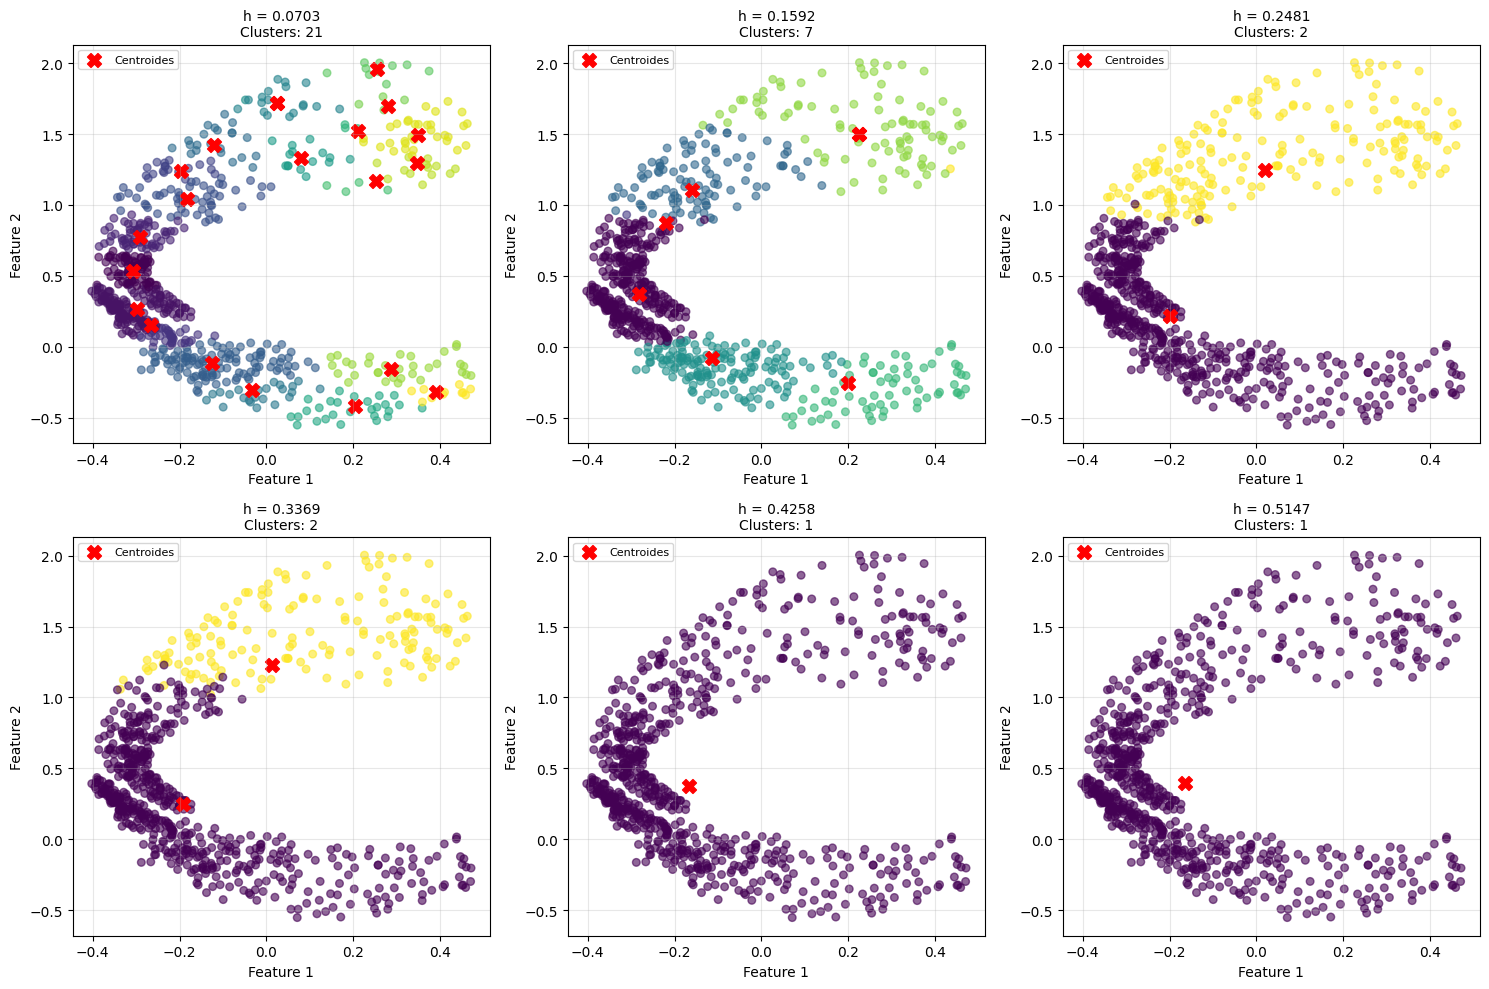


RESUMEN: NÚMERO DE CLUSTERS ENCONTRADOS
Iteración 0: Desplazamiento medio = 0.022258
Iteración 3: Desplazamiento medio = 0.017711
Iteración 6: Desplazamiento medio = 0.002585
Convergencia alcanzada en iteración 8
h = 0.0703: 21 clusters
Iteración 0: Desplazamiento medio = 0.056262
Iteración 3: Desplazamiento medio = 0.032874
Iteración 6: Desplazamiento medio = 0.006961
Convergencia alcanzada en iteración 8
h = 0.1592: 7 clusters
Iteración 0: Desplazamiento medio = 0.091058
Iteración 3: Desplazamiento medio = 0.076952
Iteración 6: Desplazamiento medio = 0.002273
Iteración 9: Desplazamiento medio = 0.001217
Iteración 12: Desplazamiento medio = 0.001191
Iteración 15: Desplazamiento medio = 0.014087
Convergencia alcanzada en iteración 17
h = 0.2481: 2 clusters
Iteración 0: Desplazamiento medio = 0.130590
Iteración 3: Desplazamiento medio = 0.048383
Iteración 6: Desplazamiento medio = 0.000413
Convergencia alcanzada en iteración 7
h = 0.3369: 2 clusters
Iteración 0: Desplazamiento medio = 

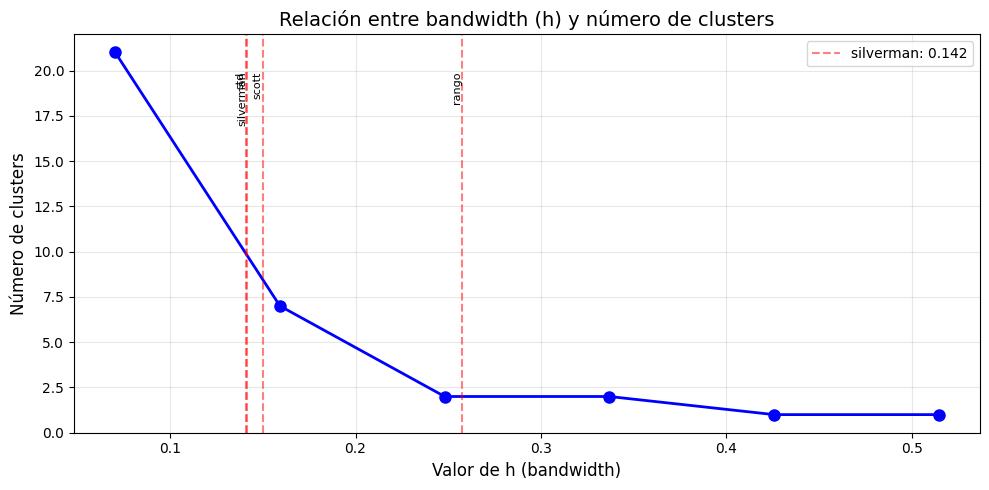

In [25]:
# p15. Experimentar con diferentes valores de h

# Definir los métodos a evaluar
metodos = ['silverman', 'scott', 'rango', 'std']

# Obtener valores de h sugeridos por los diferentes métodos
valores_h = []
nombres_metodos = []

for metodo in metodos:
    h_val, info = calcular_h_automatico(Dx, metodo)
    valores_h.append(h_val)
    nombres_metodos.append(metodo)

# Crear un rango de valores de h para experimentar
h_min = min(valores_h) * 0.5  # 50% del valor mínimo
h_max = max(valores_h) * 2.0  # 200% del valor máximo
num_experimentos = 6

hs_experimentales = np.linspace(h_min, h_max, num_experimentos)

print(f"\n" + "="*70)
print(f"EXPERIMENTACIÓN CON DIFERENTES VALORES DE h")
print(f"="*70)
print(f"Rango de h: {h_min:.4f} a {h_max:.4f}")
print(f"Número de experimentos: {num_experimentos}")
print(f"Valores de h a probar: {hs_experimentales.round(4)}")

# Crear figura para mostrar todos los resultados
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, h in enumerate(hs_experimentales):
    # Aplicar Mean Shift con el valor actual de h
    centroides, etiquetas, trayectorias = agrupamiento_densidad_MeanShift(
        Dx, h, n_iteraciones=30, tolerancia=1e-4
    )

    # Graficar resultados
    ax = axes[idx]
    scatter = ax.scatter(Dx[:, 0], Dx[:, 1], c=etiquetas,
                        cmap='viridis', alpha=0.6, s=30)
    ax.scatter(centroides[:, 0], centroides[:, 1],
              c='red', marker='X', s=100, label='Centroides')

    # Añadir información al gráfico
    ax.set_title(f'h = {h:.4f}\nClusters: {len(centroides)}', fontsize=10)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# También podemos crear un gráfico resumen del número de clusters vs h
print(f"\n" + "="*70)
print(f"RESUMEN: NÚMERO DE CLUSTERS ENCONTRADOS")
print(f"="*70)

num_clusters_por_h = []
for h in hs_experimentales:
    centroides, etiquetas, _ = agrupamiento_densidad_MeanShift(
        Dx, h, n_iteraciones=30, tolerancia=1e-4
    )
    num_clusters_por_h.append(len(centroides))
    print(f"h = {h:.4f}: {len(centroides)} clusters")

# Gráfico de resumen
plt.figure(figsize=(10, 5))
plt.plot(hs_experimentales, num_clusters_por_h, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Valor de h (bandwidth)', fontsize=12)
plt.ylabel('Número de clusters', fontsize=12)
plt.title('Relación entre bandwidth (h) y número de clusters', fontsize=14)
plt.grid(True, alpha=0.3)

# Añadir marcas para los valores calculados automáticamente
for i, (metodo, h_val) in enumerate(zip(nombres_metodos, valores_h)):
    plt.axvline(x=h_val, color='r', linestyle='--', alpha=0.5,
                label=f'{metodo}: {h_val:.3f}' if i == 0 else None)
    plt.text(h_val, max(num_clusters_por_h)*0.95, metodo,
             rotation=90, ha='right', va='top', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

<hr>
<h2>Implementaciones en librerías de Python</h2>

Scikit-learn (scikit-learn) es la implementación más popular y ampliamente utilizada:

In [26]:
from sklearn.cluster import MeanShift

# Uso básico
ms = MeanShift(bandwidth=0.5)
ms.fit(Dx)

# Obtener resultados
etiquetas = ms.labels_
centros = ms.cluster_centers_

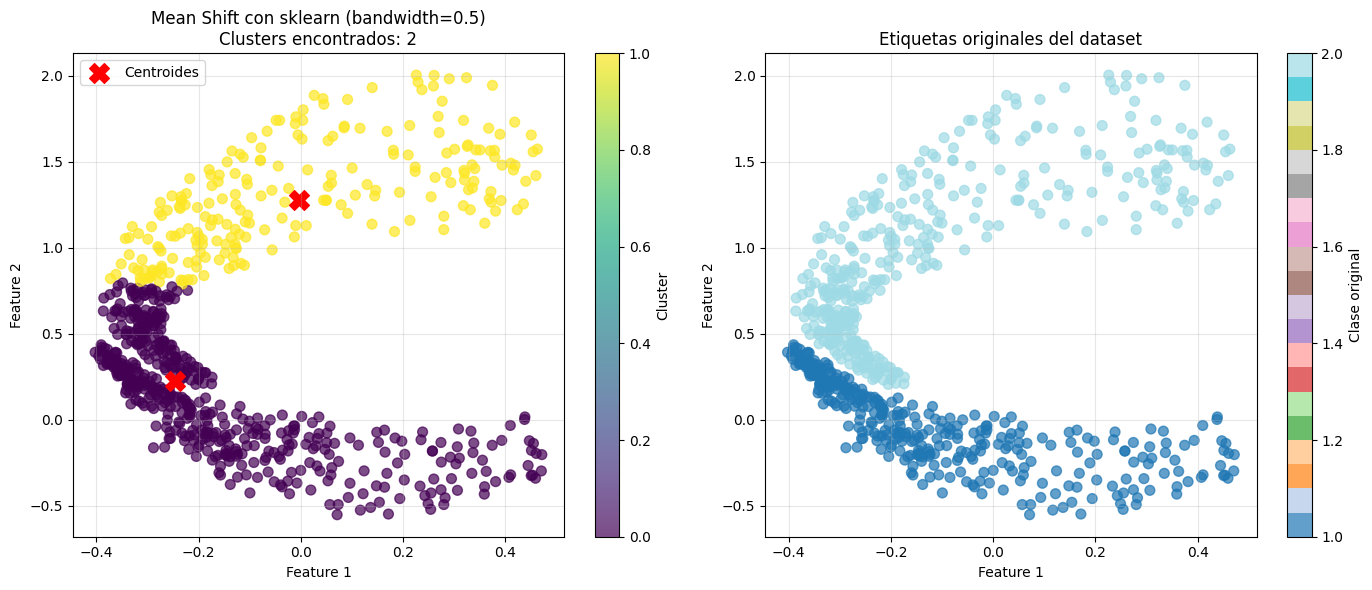


INFORMACIÓN DEL CLUSTERING CON SKLEARN MEAN SHIFT
Número de clusters encontrados: 2
Número de puntos por cluster:
  Cluster 0: 523 puntos
  Cluster 1: 224 puntos

Coordenadas de los centroides:
  Centroide 0: [-0.2463, 0.2273]
  Centroide 1: [-0.0042, 1.2768]


In [27]:
# P16 GRAFICAR LOS GRUPOS CON SKLEARN

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Resultados de Mean Shift de sklearn
scatter1 = axes[0].scatter(Dx[:, 0], Dx[:, 1], c=etiquetas,
                          cmap='viridis', alpha=0.7, s=50)
axes[0].scatter(centros[:, 0], centros[:, 1],
               c='red', marker='X', s=200, label='Centroides')
axes[0].set_title(f'Mean Shift con sklearn (bandwidth=0.5)\nClusters encontrados: {len(centros)}', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir barra de colores para los clusters
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Gráfico 2: Comparación con etiquetas originales (si están disponibles)
if 'Dy' in locals() or 'Dy' in globals():
    try:
        scatter2 = axes[1].scatter(Dx[:, 0], Dx[:, 1], c=Dy,
                                  cmap='tab20', alpha=0.7, s=50)
        axes[1].set_title('Etiquetas originales del dataset', fontsize=12)
        axes[1].set_xlabel('Feature 1')
        axes[1].set_ylabel('Feature 2')
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=axes[1], label='Clase original')
    except:
        # Si no hay etiquetas originales, mostrar solo los datos
        axes[1].scatter(Dx[:, 0], Dx[:, 1], alpha=0.7, s=50)
        axes[1].set_title('Distribución de los datos', fontsize=12)
        axes[1].set_xlabel('Feature 1')
        axes[1].set_ylabel('Feature 2')
        axes[1].grid(True, alpha=0.3)
else:
    # Si no hay etiquetas originales, mostrar solo los datos
    axes[1].scatter(Dx[:, 0], Dx[:, 1], alpha=0.7, s=50)
    axes[1].set_title('Distribución de los datos', fontsize=12)
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información adicional sobre los clusters encontrados
print(f"\n" + "="*60)
print("INFORMACIÓN DEL CLUSTERING CON SKLEARN MEAN SHIFT")
print("="*60)
print(f"Número de clusters encontrados: {len(centros)}")
print(f"Número de puntos por cluster:")
unique, counts = np.unique(etiquetas, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} puntos")

print(f"\nCoordenadas de los centroides:")
for i, centro in enumerate(centros):
    print(f"  Centroide {i}: [{centro[0]:.4f}, {centro[1]:.4f}]")

# 🚀 ¡TALLER FINALIZADO!"